# Laboratorio 6

Introducción al uso de redes convolucionales

## 1. Librerías

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import requests
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

## 2. Cargar datos de CIFAR

In [ ]:
# Imagenes de cifar100
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data(label_mode="fine")

print(f"x_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {X_test.shape} - y_test shape: {y_test.shape}")
print(f"número de categorías {len(np.unique(y_train))}")

# Numero de clases como variable
k = 100

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)
número de categorías 100


## 3. Pre-procesamiento

A diferencia del laboratorio 4, no aplanamos los datos porque las CNN toman estructuras en 2D.

In [ ]:
# División - estamos estratificando por y (util cuando hay desbalance)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# Normalizar los pixeles entre 0 and 1
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
print("Nueva distribución:", X_train.min(), X_train.max())



# Hacemos y one-hot encoded
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_val = tf.keras.utils.to_categorical(y_val, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)
print(y_train.shape)

Nueva distribución: 0.0 1.0
(35000, 100)


In [ ]:
X_train.shape

(35000, 32, 32, 3)

## 4. Arquitectura del modelo y entrenamiento

Usaremos 2 bloques completos de convoluciones + una capa convolucional seguida por una densa y la de clasificación de salida.

En convoluciones, por defecto tenemos:
* Paso: strides=(1, 1), es decir 1 pixel a la vez
* Relleno: padding="valid", que es lo mismo a no padding/relleno

In [ ]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(k, activation="softmax"))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │           6,500 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,420 (501.64 KB)

 Trainable params: 128,420 (501.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Cómo calcular el número de parámetros en cada capa:
#32*(3*3)*3 + 32
64*((3*3)*32+1)


18496

Por qué se utilizan los números anteriores para calcular el número de parámetros en una red convolucional?
Por qué la de pooling no tiene ningún parámetro?

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 76s 125ms/step - accuracy: 0.0385 - loss: 4.3679 - val_accuracy: 0.1205 - val_loss: 3.7720
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 65s 119ms/step - accuracy: 0.1455 - loss: 3.6143 - val_accuracy: 0.1850 - val_loss: 3.4108
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 82s 120ms/step - accuracy: 0.2073 - loss: 3.2750 - val_accuracy: 0.2258 - val_loss: 3.1788
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 60s 110ms/step - accuracy: 0.2440 - loss: 3.0608 - val_accuracy: 0.2519 - val_loss: 3.0680
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 89s 123ms/step - accuracy: 0.2761 - loss: 2.9124 - val_accuracy: 0.2717 - val_loss: 2.9569
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 75s 111ms/step - accuracy: 0.3040 - loss: 2.7515 - val_accuracy: 0.2865 - val_loss: 2.8656
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 89s 123ms/step - accuracy: 0.3311 - loss: 2.6173 - val_accuracy: 0.2978 - val_loss: 2.8208
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 79s 118ms/step - accuracy: 0.3495 - loss: 2

Anteriormente, habíamos obtenido 20% de accuracy en validación con MLP utilizando similares parámetros

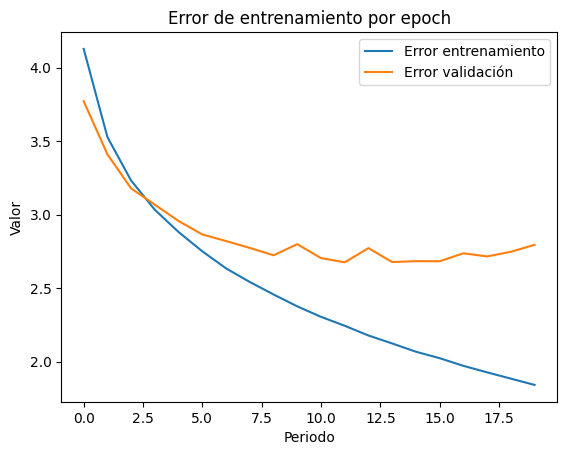

In [ ]:
# Ver resultados en entrenamiento y validación
plt.plot(history.history["loss"], label="Error entrenamiento")
plt.plot(history.history["val_loss"], label="Error validación")
plt.title("Error de entrenamiento por epoch")
plt.xlabel("Periodo")
plt.ylabel("Valor")
plt.legend()
plt.show()

## 5. Valoración del rendimiento en el set de testeo

In [ ]:
# Etiquetas
url = "https://raw.githubusercontent.com/MartinThoma/algorithms/master/ML/confusion-matrix/labels/cifar-100-labels.json"
# Traer contenido
response = requests.get(url)
# Cargar json
label_data = json.loads(response.text)

In [ ]:
# Obteniendo accuracy general
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.772010087966919
Test accuracy: 0.3402000069618225


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


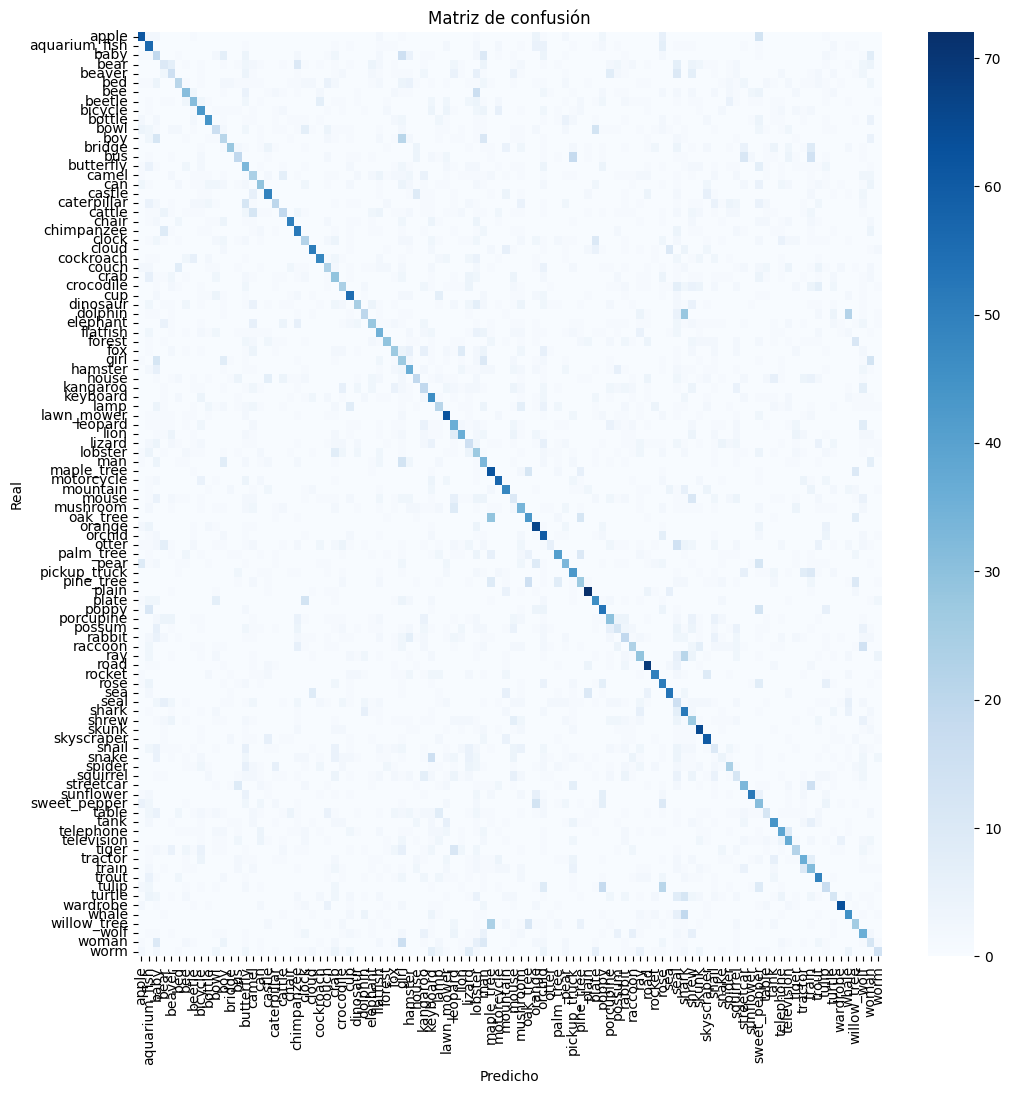

In [ ]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Create confusion matrix
reales = np.argmax(y_test, axis=1)
predichos = np.argmax(model.predict(X_test), axis=1)
num_clases = 100
conf_matrix = confusion_matrix(reales, predichos)

# Plot confusion matrix using seaborn
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues',
            xticklabels=[i for i in label_data],
            yticklabels=[i for i in label_data])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()

# Tarea moral

Utilizar el mismo modelo y proceso en este laboratorio en CIFAR10 y no CIFAR100. Qué tanto mejor es el modelo a este nivel de granularidad de datos?

## Uso de modelo pre-entrenado

In [ ]:

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Cargar el modelo pre-entrenado ResNet50 (sin la capa de clasificación)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Agregar capas personalizadas para clasificación
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(k, activation='softmax')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,788,388 (98.37 MB)

 Trainable params: 2,200,676 (8.39 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Ejercicio: Entrenar el model y mostrar los gráficos de error de entrenamiento y validación

In [ ]:
# TU CODIGO AQUI
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 278s 491ms/step - accuracy: 0.0154 - loss: 4.6923 - val_accuracy: 0.0270 - val_loss: 4.4923
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 262s 479ms/step - accuracy: 0.0348 - loss: 4.4179 - val_accuracy: 0.0491 - val_loss: 4.3338
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 245s 449ms/step - accuracy: 0.0526 - loss: 4.2985 - val_accuracy: 0.0611 - val_loss: 4.2512
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 282s 486ms/step - accuracy: 0.0655 - loss: 4.2271 - val_accuracy: 0.0667 - val_loss: 4.2381
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 320s 484ms/step - accuracy: 0.0702 - loss: 4.1866 - val_accuracy: 0.0713 - val_loss: 4.1799
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 310s 462ms/step - accuracy: 0.0789 - loss: 4.1406 - val_accuracy: 0.0806 - val_loss: 4.1430
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 234s 410ms/step - accuracy: 0.0847 - loss: 4.1062 - val_accuracy: 0.0833 - val_loss: 4.1288
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 220s 402ms/step - accuracy: 0.0868 -

Ejercicio: Calcular el rendimiento del modelo en el set de testeo en % de aciertos total y matriz de confusión

In [ ]:
# TU CODIGO AQUI
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 3.905590534210205
Test accuracy: 0.11659999936819077


## Otros temas adicionales que ayudan a la mejora de rendimiento y a la explicabilidad del modelo

Cómo agregar aumento de datos (veremos más en clase sobre este tema conceptualmente)

In [ ]:
# Se crea una instancia de "image data generator" con los distintos tipos de aumentación que se quieran
datagen = ImageDataGenerator(
    rotation_range=15,          # Random rotation
    width_shift_range=0.1,      # Random horizontal shift
    height_shift_range=0.1,     # Random vertical shift
    horizontal_flip=True,       # Random horizontal flip
    zoom_range=0.1              # Random zoom
)

# Se ajusta el generador a los datos de entrenamiento
datagen.fit(X_train)

# Se usa datagen.flow() para aumentar los datos
train_generator = datagen.flow(X_train, y_train, batch_size=64)

# Se entrena con los nuevos datos de entrenamiento aumentados
model.fit(train_generator, epochs=10, validation_data=(X_val, y_val))

NameError: name 'ImageDataGenerator' is not defined

Cómo visualizar interpretabilidad (prueba si funciona adecuadamente para este modelo)

In [ ]:
!pip install shap

# Muestra de 1 imagen
sample_data = X_test[0]
plt.imshow(sample_data)
plt.title('Imagen de ejemplo')
plt.show()
# SHAP explainer
explainer = shap.GradientExplainer(model, X_train)
# Explicar las predicciones de la muestra
shap_values = explainer.shap_values(sample_data)
# Visualize SHAP values for the first sample (image 0)
shap.image_plot(shap_values, sample_data)

Modelos más poderosos: https://keras.io/api/applications/

In [ ]:
# Se pueden usar otras arquitecturas ya desarrolladas tanto pre-entrenadas como no pre-entrenadas
# Ejemplo de una con pesos imagenet (como la utilizada este laboratorio)
keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name="resnet50",
)
# Ejemplo de una sin pre-entrenar. Pesos inicializados aleatorios
keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name="resnet50",
)

Qué podría mejorar este modelo?

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation
datagen = ImageDataGenerator(rescale=1./255,
                             horizontal_flip=True,
                             zoom_range=0.2,
                             rotation_range=20)


# Function to resize images
def resize_images(images, target_size=(64, 64)):
    resized_images = []
    for img in images:
        resized_img = tf.image.resize(img, target_size)  # Resize image
        resized_images.append(resized_img)
    return np.array(resized_images)

# Resize training and test images
X_train = resize_images(X_train)
X_val = resize_images(X_val)
X_test = resize_images(X_test)

# Generator
train_generator = datagen.flow(X_train, y_train, batch_size=16)

# Cargar el modelo pre-entrenado ResNet50 (sin la capa de clasificación)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Agregar capas personalizadas para clasificación
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(k, activation='softmax')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_generator, epochs=5, batch_size=16, validation_data=(X_val, y_val))
